In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Import all necessary PyTorch and Torch Vision packages
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset

# Load the dataset to train for calssifying cracked and non-cracked surfaces
from PIL import Image
from collections import defaultdict

# Load package to measure the time it takes to run the training and test
from pytictoc import TicToc
from tqdm import trange
from tqdm import tqdm


# Path to the directory containing the images
data_path = "archive"  # Replace "/path/to/dataset" with the actual path
t = TicToc()           # Initialise timimng function

In [2]:
!nvidia-smi

Mon Mar 25 16:37:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              9W /   80W |     129MiB /   6144MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print(torch.__version__)

True
2.2.1


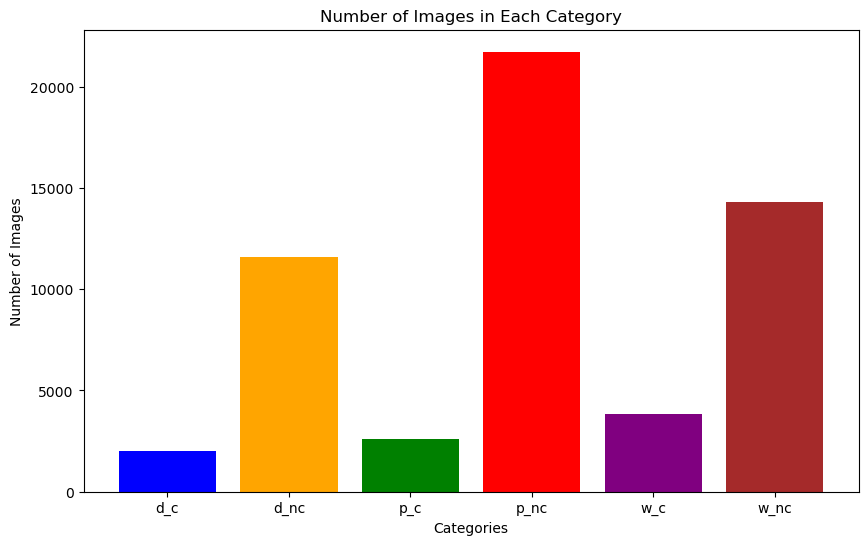

[2025, 11595, 2608, 21726, 3851, 14287]


In [4]:
# Data categories
categories = ['Decks/Cracked', 'Decks/Non-cracked', 'Pavements/Cracked', 'Pavements/Non-cracked', 'Walls/Cracked', 'Walls/Non-cracked']
category_names = ['d_c', 'd_nc', 'p_c', 'p_nc', 'w_c', 'w_nc']
image_counts = []

# Count number of images in each category
for category in categories:
    category_path = os.path.join(os.getcwd(), data_path, category).replace('\\','/')
    image_count = len(os.listdir(category_path))
    image_counts.append(image_count)

# Create histogram
plt.figure(figsize=(10, 6))
plt.bar(category_names, image_counts, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')

# Show histogram
plt.show()
print(image_counts)

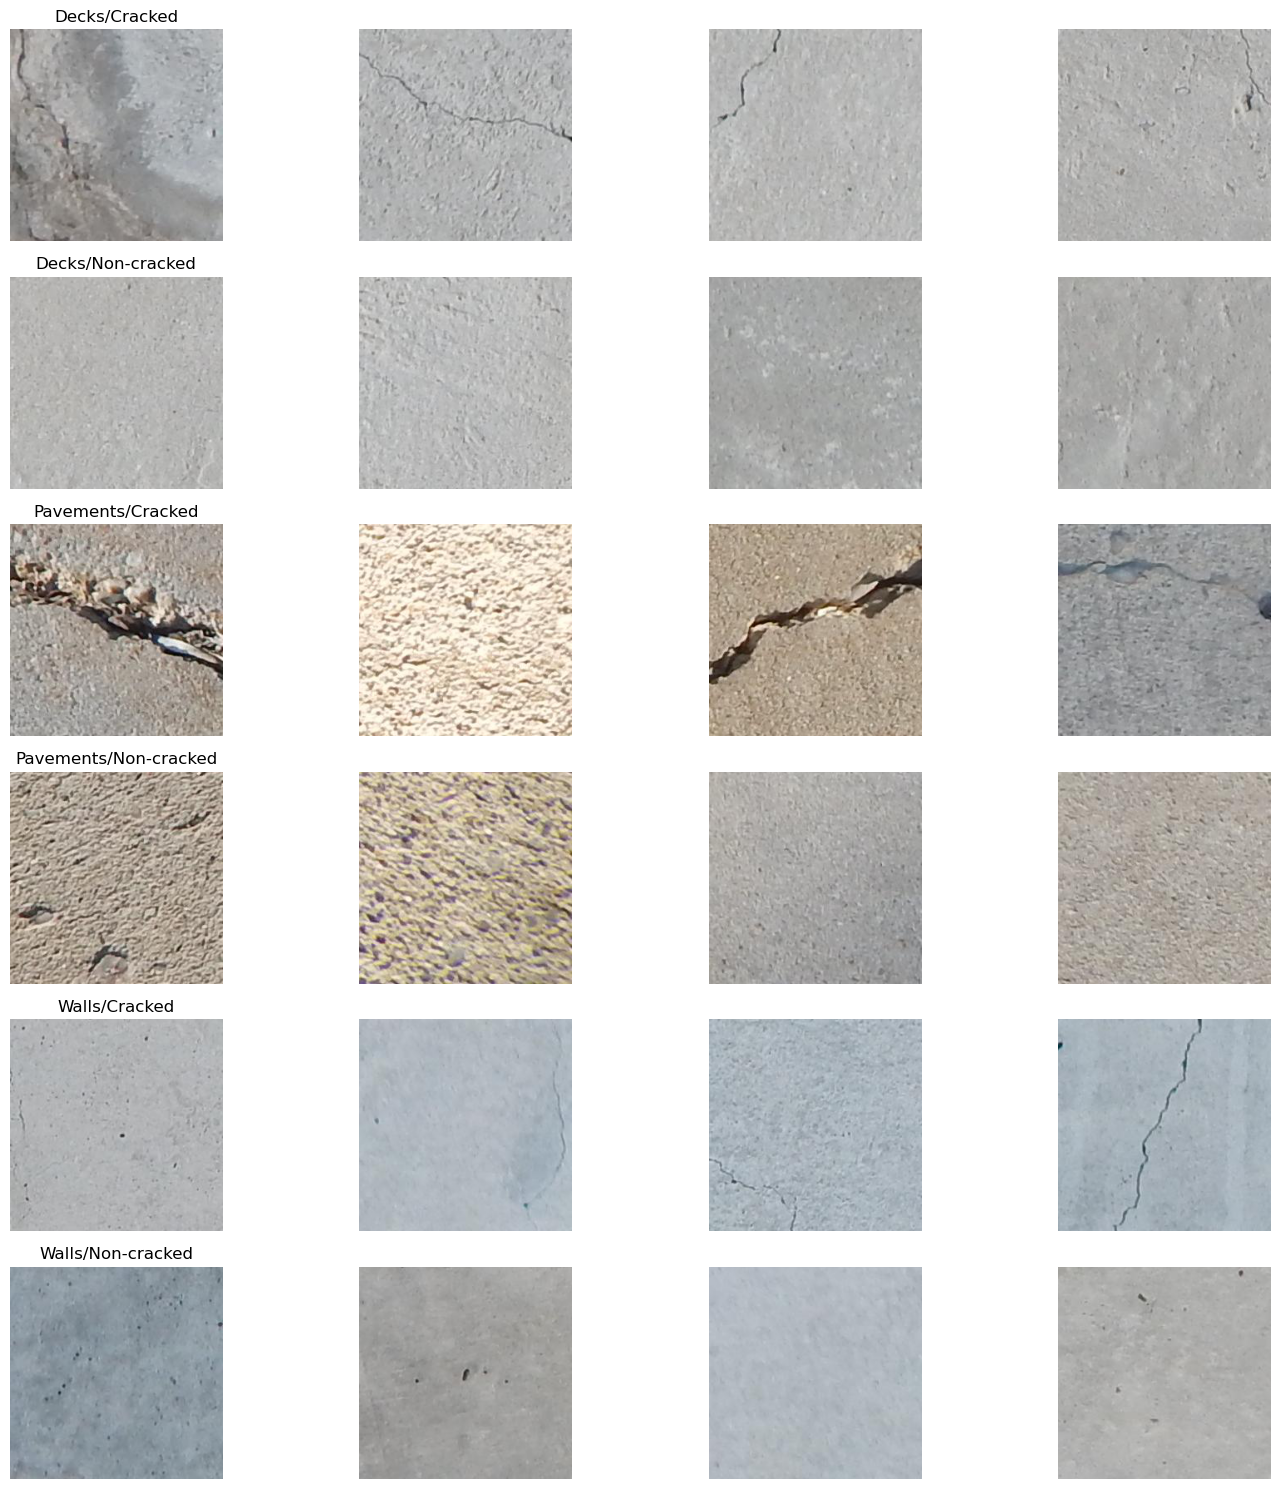

In [5]:
num_images_per_category = 4

# Create a subplots
fig, axs = plt.subplots(len(categories), num_images_per_category, figsize=(15, 15))

# Iterate over each category
for i, category in enumerate(categories):
    category_path = os.path.join(os.getcwd(), data_path, category)
    image_files = os.listdir(category_path)
    # Choose four random images from the category
    random_images = random.sample(image_files, num_images_per_category)
    # Display each random image in the corresponding subplot
    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_path, image_file)
        img = mpimg.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

# Title of subplots
for ax, category in zip(axs[:,0], categories):
    ax.set_title(category)

#Show random images
plt.tight_layout()
plt.show()

# Dataset
The dataset is divided into three catagories:
* Decks
* Pavements
* Walls

These catagories are then all further divided into:
* Cracked
* non-cracked

Each catagory contains the following number of pictures:
* Decks, cracked: 2025 pictures
* Decks, non-cracked: 11595 pictures
* Pavements, cracked: 2608 pictures
* Pavements, non-cracked: 21726 pictures
* Walls, cracked: 3851 pictures
* Walls, non-cracked: 14287 pictures

For a total dataset of 56092 pictures

# Dataset use
From the histogram we see that in general there are many more non-cracked images, compared with cracked images. Therefore, it would be benificial to reduce the number non-cracked images used in training, such that the number of cracked and non-cracked images are similar in number. Otherwise, it will lead to a relative over training in detecting non-cracked images, meaning cracked photos are more likely to be miss classified as non-cracked.

Furthermore, it is important to remember to divide the data up, such that there is a training set and a test set, or even perhaps divide the data such that cross-validation may be used.

In [6]:
# Define the standard transform
std_transform = transforms.Compose([ transforms.ToTensor()])

# Define batch size
batch_size = 32

In [7]:
# Function for finding transform for data loading based on mean and variance of data-set
def calculate_mean_std(dataset, batch_size=1000):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)  # Initialize mean
    var = torch.zeros(3)   # Initialize variance
    num_samples = 0  # Count total number of samples

    for inputs, _ in loader:
        batch_size = inputs.size(0)
        num_samples += batch_size
        # Compute mean and std per channel
        mean += torch.mean(inputs, dim=(0, 2, 3)) * batch_size

    # Calculate variance
    for inputs, _ in loader:
        var += torch.sum((inputs - mean.view(1, 3, 1, 1)) ** 2, dim=(0, 2, 3))

    std = torch.sqrt(var / (num_samples * dataset[0][0].size(1) * dataset[0][0].size(2)))

    # Normalize by the total number of samples
    mean /= num_samples
    std /= num_samples

    return mean, std

def get_normalized_transform(dataset, batch_size=100):
    mean, std = calculate_mean_std(dataset, batch_size=batch_size)
    normalize_transform = transforms.Normalize(mean, std)

    return transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images to 256x256
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        normalize_transform  # Normalize images using computed mean and std
    ])


# Function that splits data into a training and test set with user defined ratio
def split_data(data, training_ratio):
  train_size = int(training_ratio * len(data))
  test_size = len(data) - train_size
  train_set, test_set = random_split(data, [train_size, test_size])
  return train_set, test_set

# Replace the torchvision datasets.ImageFolder with a custom one that correctly assigns classes based on own desired class division
class CustomImageFolderDataset(Dataset):
    def __init__(self, data_list, classes, transform=None):
        self.data_list = data_list
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path, label = self.data_list[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
t.tic()
# Define the main categories
categories = ['Decks', 'Pavements', 'Walls']

# Define the classes
classes = ['Cracked', 'Non-cracked']

# Define the number of samples to use for each category and subcategory
# This is done as the number of non-cracked images heavily outweigh the cracked images
# to re-balance the data-set
num_samples_per_category = {
    'Decks': {'Cracked': 2025, 'Non-cracked': 2500},
    'Pavements': {'Cracked': 2608, 'Non-cracked': 2700},
    'Walls': {'Cracked': 3851, 'Non-cracked': 3900}
}

# List to store samples
indices = [] # This will contain tuples with following structure:
#[('sampled_image_data_path', class), ...] where class is a 1 or 0

# Iterate over each category
for category in categories:
    # Define the path to the category
    category_path = os.path.join(data_path, category)

    # Iterate over each subcategory (Cracked and Non-cracked)
    for subcategory, num_samples in num_samples_per_category[category].items():
        # Define the path to the subcategory
        subcategory_path = os.path.join(category_path, subcategory)

        # Sample indices from the subcategory
        subcategory_indices = random.sample(range(len(os.listdir(subcategory_path))), num_samples)

        # Combine the sampled indices
        indices.extend([(os.path.join(subcategory_path, os.listdir(subcategory_path)[idx]), 0 if subcategory == 'Cracked' else 1) for idx in subcategory_indices])

# Create custom dataset
crack_data = CustomImageFolderDataset(indices, classes, transform=std_transform)

# Normalize dataset
crack_transform = get_normalized_transform(crack_data)
crack_data = CustomImageFolderDataset(indices, classes, transform=crack_transform)

# Check the class names
class_names = crack_data.classes

print("Catagory names names:", class_names)

# Split data
train_crack_set, test_crack_set = split_data(crack_data, 0.8)

# Load data
crack_train_dataset_loader =  torch.utils.data.DataLoader(train_crack_set, batch_size=32, shuffle=True)
crack_test_dataset_loader =  torch.utils.data.DataLoader(test_crack_set, batch_size=32, shuffle=True)
t.toc()

KeyboardInterrupt: 

In [ ]:
print(len(crack_train_dataset_loader))

In [ ]:
# # Check that the custom fucntion asigns classes correctly
# t.tic()

# # Create a DataLoader with batch_size=1 to iterate over the dataset
# data_loader = DataLoader(crack_data)

# # Initialize a defaultdict to count samples for each class
# class_counts = defaultdict(int)

# # Iterate over the DataLoader and count samples for each class
# for _, label in data_loader:
#     class_counts[label.item()] += 1

# # Print the class counts
# print("Class Counts:")
# for class_idx, count in class_counts.items():
#     class_name = classes[class_idx]
#     print(f"{class_name}: {count}")
    
# t.toc()

In [ ]:
# General CNN structure with number of classes as variable
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(16, 30, kernel_size=5, padding=1)

        # Adjusted fully connected layer input size based on the updated convolutional layers
        self.fc1 = nn.Linear(30 * 30 * 30, 120)  # 62 = (original_img_sz / kernel_stride) - n_max_pools
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # Update the output size based on num_classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [ ]:
# # CNN for catagorizing deck, pavement, and wall
# cnn3 = CNN(num_classes = 3)

# # Definition of criterion and optimizer for each CNN
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn3.parameters(), lr=0.001, momentum=0.7)

In [ ]:
# CNN for identifying cracks
cnn2 = CNN(num_classes = 2)

# Definition of criterion and optimizer for each CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# # Training CNN3
# t.tic()
# for epoch in trange(5):  # loop over the dataset multiple times

#     for i, data in tqdm(enumerate(category_train_dataset_loader, 0),desc="Loop", position=0, leave=True):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = cnn3(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
# train_time = t.toc()
# print('Finished Training')

In [ ]:
# Training CNN2
t.tic()
for epoch in trange(5):  # loop over the dataset multiple times

    for i, data in tqdm(enumerate(crack_train_dataset_loader, 0),desc="Loop", position=0, leave=True):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
train_time = t.toc()
print('Finished Training')

In [ ]:
# # Testing CNN3
# t.tic()
# # Set the model to evaluation mode
# cnn3.eval()

# # Initialize variables for tracking accuracy
# correct = 0
# total = 0

# # Iterate through batches of the test DataLoader
# with torch.no_grad():  # No need to track gradients during inference
#     for inputs, labels in category_test_dataset_loader:
#         # Move inputs and labels to the device (e.g., GPU) if available
#         #inputs, labels = inputs.to('cuda'), labels.to('cuda')

#         # Forward pass
#         outputs = cnn3(inputs)

#         # Get predictions
#         _, predicted = torch.max(outputs, 1)

#         # Update accuracy
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# # Calculate accuracy
# accuracy = correct / total
# t.toc()
# print(f'Test Accuracy: {accuracy:.2%}')

In [ ]:
# Testing CNN2
t.tic()
# Set the model to evaluation mode
cnn2.eval()

# Initialize variables for tracking accuracy
correct = 0
total = 0

# Iterate through batches of the test DataLoader
with torch.no_grad():  # No need to track gradients during inference
    for inputs, labels in crack_test_dataset_loader:
        # Move inputs and labels to the device (e.g., GPU) if available
        #inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = cnn2(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Update accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
t.toc()
print(f'Test Accuracy: {accuracy:.2%}')
print(f'Total: {total:.2}')

# Misslabeled data examples

## Decks
SIDE BY SIDE
CRACKED: 7014-196, NON-CRACKED: 7001-72

### Cracked
7001-151 <br>
7002-162 <br>
7003-166 <br>
7007-127 <br>

### Non-cracked
7009-149 <br>
7014 Has a questional part from 7014-1 to 7014-70 <br>
7015 Same problem as 7014 <br>
7016 Same problem as 7014 <br>

## Pavement

### Cracked
005-2 <br>
005-9 <br>
005-10 <br>
005-11 <br>
014-195 <br>
029-45 <br>
029-46 <br>
029-47 <br>
029-48 <br>
029-49 <br>
029-50 <br>

### Non-cracked
009-1 <br>
009-2 <br>
009-19 <br>
010-18 <br>
011-10 <br>
011-21 <br>
011-28 <br>
011-46 <br>
Picture 011, has a lot of misclassified pictures. <br>
018-1 <br>
018-14 <br> 
018-19 <br>
020-15 <br>
020-33 <br>
020-34 <br>
020-52 <br>

## Walls

### Cracked
7069-25 <br>
7069-49 <br>
7069-51 <br>
7069-69 <br>

### Non-cracked
7075-69 <br>
7075-70 <br>
7078-230 <br>

